# Лабораторная работа №5 "Проведение исследований со градиентным бустингом"

## Подключение вспомогательных библиотек

In [38]:
from dataclasses import dataclass
from typing import Union

import collections
import math
import tqdm

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import sklearn.metrics
import sklearn.model_selection
import sklearn.ensemble
import sklearn.utils

## Классификация

### 2. Создание бейзлайна и оценка качества

#### Подготовка бейзлайна

Перед началом обучения модели сформируем бейзлайн, подобно тому, как это было выполнено в рамках лабораторной работы №1

In [2]:
!kaggle datasets download -q -p dataset -d saurabhbadole/bank-customer-churn-prediction-dataset
!unzip dataset/bank-customer-churn-prediction-dataset.zip -d dataset/

ds = pd.read_csv("dataset/Churn_Modelling.csv")
ds.head()

baseline_ds = ds.drop(columns=["RowNumber", "CustomerId", "Surname"])

baseline_ds = pd.get_dummies(baseline_ds, columns=["Geography"], dtype=int)
baseline_ds = pd.get_dummies(baseline_ds, columns=["Gender"], dtype=int)

baseline_ds.head()

Dataset URL: https://www.kaggle.com/datasets/saurabhbadole/bank-customer-churn-prediction-dataset
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
Archive:  dataset/bank-customer-churn-prediction-dataset.zip
  inflating: dataset/Churn_Modelling.csv  


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0


#### Обучение модели

Перейдем теперь к этапу обучения модели. По аналогии с лабораторной работой №1, для этого создадим вспомогательные функции:

- `generate_train_data` - отвечает за то, чтобы сгенерировать набор данных для тестирования и обучения на основе переданного датасета

- `get_model_metrics` - отвечает за рассчет показаний метрик для уже обученной модели на основе тестовых данных

- `print_model_metrics` - отвечает за отформатированный вывод показаний метрик

In [3]:
def generate_train_data(dataset, *, target_feature="Exited", random_state=42, test_size=0.2):
  X = dataset.drop(columns=[target_feature])
  y = dataset[target_feature]

  X_train, X_test, y_train, y_test = map(
    np.array,
    sklearn.model_selection.train_test_split(
      X, y,
      test_size=test_size,
      random_state=random_state,
    ),
  )

  return (X_train, y_train), (X_test, y_test)


def get_model_metrics(model, X_test, y_test):
  y_pred = model.predict(X_test)

  accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
  precision = sklearn.metrics.precision_score(y_test, y_pred)
  recall = sklearn.metrics.recall_score(y_test, y_pred)
  f1 = sklearn.metrics.f1_score(y_test, y_pred)

  confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)

  return {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "confusion_matrix": confusion_matrix,
  }


def print_model_metrics(model, X_test, y_test):
  metrics = get_model_metrics(model, X_test, y_test)

  print(f"Accuracy: {metrics['accuracy']:.4f}")
  print(f"Precision: {metrics['precision']:.4f}")
  print(f"Recall: {metrics['recall']:.4f}")
  print(f"F1-Score: {metrics['f1']:.4f}")

  print("\nConfusion Matrix:")
  print(metrics["confusion_matrix"])


Обучим теперь модель градиентного бустинга для решения задачи классификации на бейзлайн-датасете, который мы ранее определили, и выведем на экран показатели метрик для итоговой обученной модели.

In [4]:
(X_train, y_train), (X_test, y_test) = generate_train_data(baseline_ds)

model = sklearn.ensemble.GradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Accuracy: 0.8640
Precision: 0.7410
Recall: 0.4733
F1-Score: 0.5776

Confusion Matrix:
[[1542   65]
 [ 207  186]]


На основе полученных данных можно сделать следующие выводы о качестве обученной модели.

Высокие значения метрики "Accuracy" говорят о том, что модель хороша справляется с проблемой ложных срабатываний. Но стоит также учитывать, что в силу несбалансированности классов в датасете, данная метрика не является слишком инфомративной.

Неспособность модели работать с редким классом подчеркивается низкими показателями метрик "F1-Score" и "Recall".

Итого, при дальнейшей оптимизации бейзлайна предлагается сделать упор на редкий класс для улучшения показаний метрики "F1-Score", как это было сделано в прошлых лабораторных работах.

### 3. Улучшение бейзлайна

#### Удаление лишних признаков

Аналогично с тем, как это проделано в лабораторной работе №4, применим гипотезу о наличии лишних признаков, которые мешают эффективному обучению модели, к модели градиентного бустинга.

Аналогично с прошлой лабораторной работой, воспользуемся матрицей корреляции для нахождения лишних признаков.

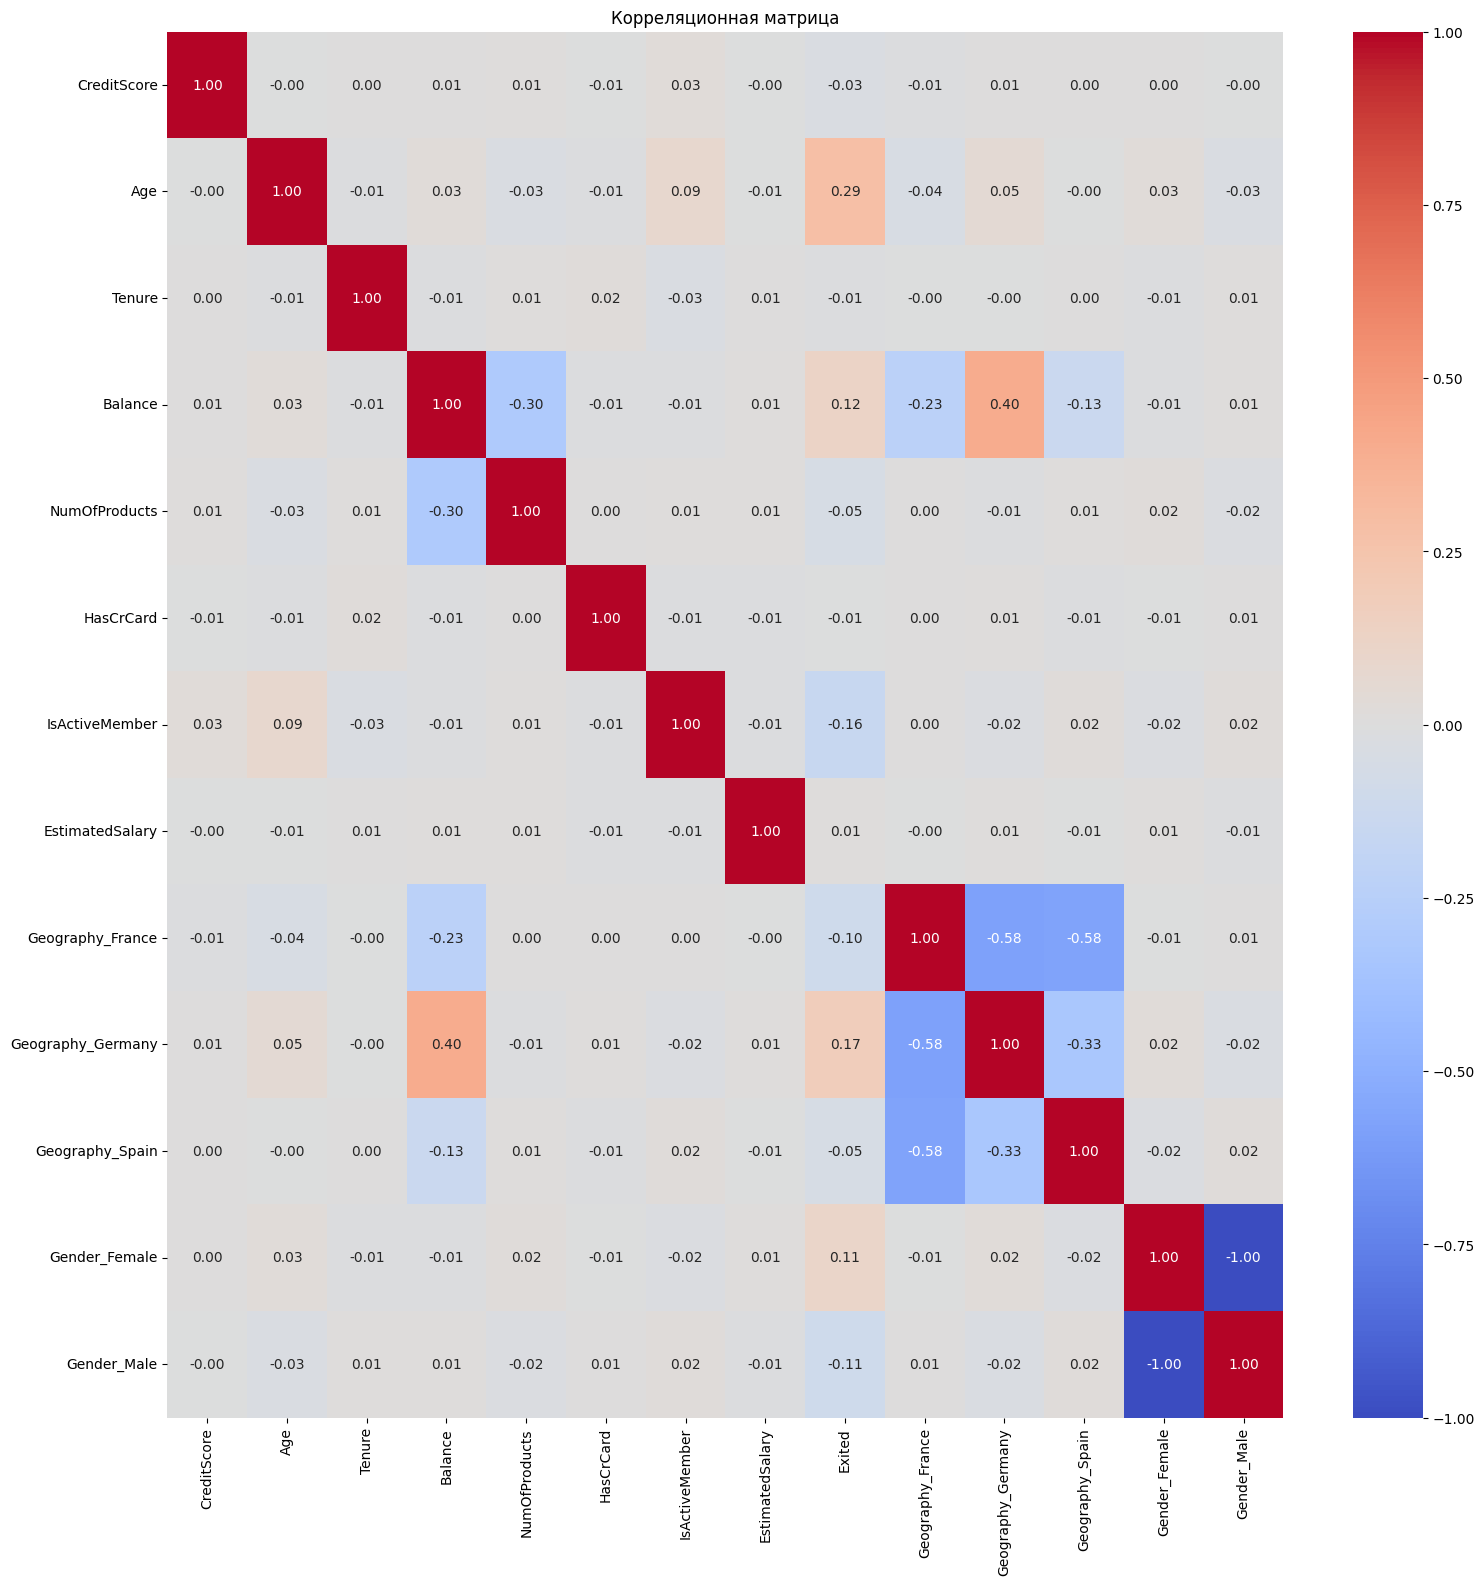

In [5]:
corr_matrix = baseline_ds.corr().drop("Exited", axis=0)

plt.figure(figsize=(18, 18))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Корреляционная матрица")
plt.show()

Как видим, у нас есть мультиколлинеарные признаки `Gender_Male` и `Geography_Germany`. Попробуем убрать их из датасета и проверить, улучшилось ли после данной оптимизации итоговое качество модели.

In [6]:
optimized_ds = baseline_ds.drop(columns=["Gender_Male", "Geography_Germany"])

# обучение модели

(X_train, y_train), (X_test, y_test) = generate_train_data(optimized_ds)

model = sklearn.ensemble.GradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Accuracy: 0.8660
Precision: 0.7551
Recall: 0.4707
F1-Score: 0.5799

Confusion Matrix:
[[1547   60]
 [ 208  185]]


Как видно, после проведенных оптимизаций значения метрик улучшились, но незначительно, что связанно с тем, что деревья решений и градиентный бустинг, основанный на них, хорошо справляются с избыточностью информации.

#### Нормализация данных

Подобно прошлым лабораторным работам, применим гипотезу о наличии несбалансированных распределений во входных данных и их возможном негативном влиянии на обучение модели.

В качестве целевого признака возьмем признак `Age`. Аналогично с прошлыми лабораторными работами, выведем графики для дальнейшего анализа на наличие несбалансированного распределения значений признака.

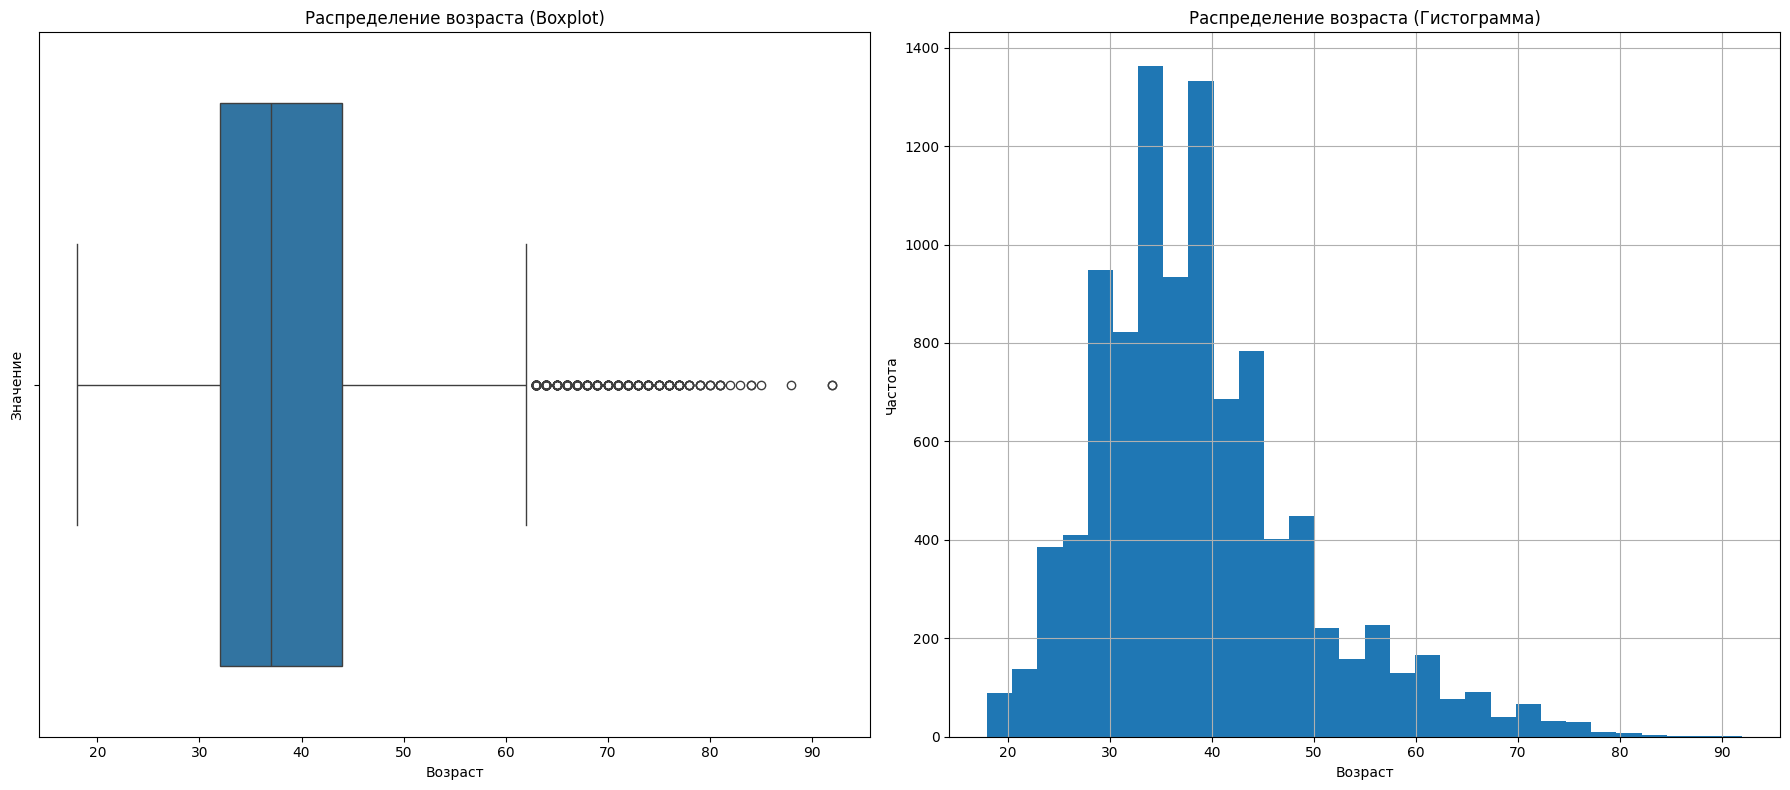

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

sns.boxplot(x=optimized_ds["Age"], ax=axes[0])
axes[0].set_title("Распределение возраста (Boxplot)")
axes[0].set_xlabel("Возраст")
axes[0].set_ylabel("Значение")

optimized_ds[["Age"]].hist(bins=30, ax=axes[1])
axes[1].set_title("Распределение возраста (Гистограмма)")
axes[1].set_xlabel("Возраст")
axes[1].set_ylabel("Частота")

plt.tight_layout()
plt.show()

Как видим, распределение значений признака `Age` действительно оказалось смещенным. Попробуем нормализовать значения, приведя распределение к нормальному, с использованием функции логарифма.

In [8]:
optimized_ds_2 = optimized_ds.copy()
optimized_ds_2["Age_log"] = np.log2(optimized_ds_2["Age"])
optimized_ds_2.drop(columns=["Age"], inplace=True)

# обучение модели

(X_train, y_train), (X_test, y_test) = generate_train_data(optimized_ds_2)

model = sklearn.ensemble.GradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Accuracy: 0.8655
Precision: 0.7541
Recall: 0.4682
F1-Score: 0.5777

Confusion Matrix:
[[1547   60]
 [ 209  184]]


Как видно по получившимся значениям метрик, применение нормализации значений не оказало положительного эффекта на качество модели, что обосновывается тем, что модели градиентного бустинга хорошо справляются с ненормализованными распределениями данных.

### 4. Имплементация алгоритма машинного обучения

Перейдем теперь к собственной имплементации алгоритма градиентного бустинга для задачи классификации. Решение я реализовал в виде класса `MyGradientBoostingClassifier`, который имеет интерфейс, схожий с тем, что используется в библиотеке `sklearn`. присутствуют 2 метода: `fit` - для обучения модели, `predict` - для предсказания классов для уже обученной модели.

Так как градиентный бустинг является ансамблевым методом, то в его работе участвуют другие модели. В нашем случае это дерево решений. В качестве такой вспомогательной модели была взята имплементация алгоритма дерева решений из лабораторной работы №3.

Также, так как процесс обучения стал значительно дольше, то была добавлена строка для отслеживания прогресса обучения модели.

In [18]:
_PredictedClass = int


@dataclass
class _SplitInfo:
  index: int
  threshold: float


@dataclass
class _TreeNode:
  split_info: _SplitInfo
  left: Union["_TreeNode", _PredictedClass]
  right: Union["_TreeNode", _PredictedClass]


class MyDecisionTreeClassifier:
  def __init__(self, *, max_depth=float("inf")):
    self.__max_depth = max_depth
    self.__tree = None

  def __build_decision_tree(self, X, y, depth=0):
    n, m = X.shape
    unique_classes = set(y)

    if len(unique_classes) == 1 or n <= 1:
      return unique_classes.pop()

    if depth >= self.__max_depth:
      return collections.Counter(y).most_common(1)[0][0]

    best_split = self._best_split(X, y)
    if best_split is None:
      raise ValueError()

    left_part, right_part = self.__split_data(X, y, best_split)

    return _TreeNode(
      split_info=best_split,
      left=self.__build_decision_tree(*left_part, depth + 1),
      right=self.__build_decision_tree(*right_part, depth + 1),
    )

  def __split_data(self, X, y, split_info):
    x = X[:, split_info.index]
    left_ids = x <= split_info.threshold
    right_ids = x > split_info.threshold

    return (X[left_ids], y[left_ids]), (X[right_ids], y[right_ids])

  def _best_split(self, X, y):
    _, m = X.shape
    best_split = max(
      (
        _SplitInfo(index=feature_index, threshold=threshold)
        for feature_index in range(m)
        for threshold in self.__get_thresholds(X, feature_index)
      ),
      key=lambda split_info: self.__get_info_gain(X, y, split_info.index, split_info.threshold),
      default=None,
    )

    if self.__get_info_gain(X, y, best_split.index, best_split.threshold) == -float("inf"):
      return None
    return best_split

  def __get_info_gain(self, X, y, feature_index, threshold):
    feature_values = X[:, feature_index]
    left_indices = feature_values <= threshold
    right_indices = feature_values > threshold

    if np.sum(left_indices) == 0 or np.sum(right_indices) == 0:
      return -float('inf')

    left_y = y[left_indices]
    right_y = y[right_indices]

    l = self.__get_entropy(left_y)
    r = self.__get_entropy(right_y)

    n = len(y)
    return self.__get_entropy(y) - (len(left_y) / n * l + len(right_y) / n * r)

  def __get_thresholds(self, X, feature_id):
    return np.unique(X[:, feature_id])

  def __get_entropy(self, y):
    class_counts = np.bincount(y.astype(int))
    probabilities = class_counts / len(y)
    return -np.sum(probabilities * np.log2(probabilities + 1e-9))

  def __predict(self, x):
    cursor = self.__tree

    while isinstance(cursor, _TreeNode):
      feature_value = x[cursor.split_info.index]
      predictor = feature_value <= cursor.split_info.threshold
      cursor = [cursor.right, cursor.left][predictor]

    return cursor

  def fit(self, X, y):
    self.__tree = self.__build_decision_tree(X, y)

  def predict(self, X):
    return np.array(list(map(self.__predict, X)))

In [34]:
def _get_mapped_y(y):
  unique_classes = np.unique(y)
  class_mapping = {cls: idx for idx, cls in enumerate(unique_classes)}
  return np.vectorize(class_mapping.get)(y)


class MyGradientBoostingClassifier:
  def __init__(self, trees_amount=10, learn_rate=0.1, max_tree_depth=3):
    self.__trees_amount = trees_amount
    self.__learn_rate = learn_rate
    self.__tree_max_depth = max_tree_depth

    self.__init_prediction = None
    self.__trees = None

  def fit(self, X, y):
    y_mapped = _get_mapped_y(y)
    trees = []

    init_pred = np.bincount(y_mapped).argmax()
    pred = np.full(y_mapped.shape, init_pred, dtype=float)

    for _ in tqdm.tqdm(range(self.__trees_amount)):
      tree = MyDecisionTreeClassifier(max_depth=self.__tree_max_depth)
      tree.fit(X, y_mapped - pred)

      tree_predictions = tree.predict(X).astype(float)
      pred += self.__learn_rate * tree_predictions

      trees.append(tree)

    self.__trees = trees
    self.__init_prediction = init_pred

  def predict(self, X):
    predictions = np.full((X.shape[0],), self.__init_prediction, dtype=float)

    for tree in self.__trees:
      predictions += self.__learn_rate * tree.predict(X)

    return predictions.astype(int)


#### Сравнение с бейзлайном

Обучим теперь реализованную модель на датасете, соответствущем бейзлайну. Из-за определенных ранее вспомогательных функций и схожего интерфейса класса модели основной алгоритм обучения не меняется.

In [41]:
(X_train, y_train), (X_test, y_test) = generate_train_data(baseline_ds)

model = MyGradientBoostingClassifier(trees_amount=30)
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

100%|██████████| 30/30 [03:29<00:00,  7.00s/it]
Precision: 0.7840
Recall: 0.2494
F1-Score: 0.3784

Confusion Matrix:
[[1580   27]
 [ 295   98]]


Как видно, по сравнению с моделью из пункта 2, имплементированная модель сильно отстает по качеству, особенно судя по метрике "F1-Score". Связанно это с использованием базового алгоритма градиентного бустинга, который не использует оптимизации, и отсутствиет богатого набора гиперпараметров для настройки модели.

In [52]:
(X_train, y_train), (X_test, y_test) = generate_train_data(optimized_ds_2)

model = MyGradientBoostingClassifier(trees_amount=30)
model.fit(np.array(X_train), np.array(y_train))

print_model_metrics(model, np.array(X_test), np.array(y_test))

100%|██████████| 30/30 [03:28<00:00,  6.95s/it]
Accuracy: 0.8674
Precision: 0.7912
Recall: 0.4315
F1-Score: 0.5598

Confusion Matrix:
[[1573   34]
 [ 227  166]]


Как видим, оптимизированный бейзлайн оказал положительное влияние на итоговое качестве имплементированный модели. Показания метрик для улучшенного бейзлайна оказались выше.

Однако, по сравнению с моделью из пункта 3, имплементированная модель работает хуже.

## Регрессия

### 2. Создание бейзлайна и оценка качества

#### Подготовка бейзлайна

Перед началом обучения модели сформируем бейзлайн, подобно тому, как это было выполнено в рамках лабораторной работы №1

In [53]:
!kaggle datasets download -q -p dataset -d denkuznetz/taxi-price-prediction
!unzip dataset/taxi-price-prediction.zip -d dataset/

Dataset URL: https://www.kaggle.com/datasets/denkuznetz/taxi-price-prediction
License(s): apache-2.0
Archive:  dataset/taxi-price-prediction.zip
  inflating: dataset/taxi_trip_pricing.csv  


In [55]:
ds = pd.read_csv("/content/dataset/taxi_trip_pricing.csv")
baseline_ds = ds.dropna(subset=["Trip_Price"])

numeric_features = [
  "Trip_Distance_km",
  "Passenger_Count",
  "Base_Fare",
  "Per_Km_Rate",
  "Per_Minute_Rate",
  "Trip_Duration_Minutes",
]
baseline_ds[numeric_features] = baseline_ds[numeric_features].apply(lambda col: col.fillna(col.median()))

categorical_features = [
  "Time_of_Day",
  "Day_of_Week",
  "Traffic_Conditions",
  "Weather",
]

for feature in categorical_features:
  encoded_feature = pd.get_dummies(baseline_ds[feature], prefix=feature, dtype=int)
  baseline_ds[encoded_feature.columns] = encoded_feature
  baseline_ds = baseline_ds.drop(columns=[feature])

baseline_ds.head()

,Trip_Distance_km,Passenger_Count,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price,Time_of_Day_Afternoon,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,Day_of_Week_Weekday,Day_of_Week_Weekend,Traffic_Conditions_High,Traffic_Conditions_Low,Traffic_Conditions_Medium,Weather_Clear,Weather_Rain,Weather_Snow
0,19.35,3.0,3.56,0.80,0.32,53.82,36.2624,0,0,1,0,1,0,0,1,0,1,0,0
2,36.87,1.0,2.70,1.21,0.15,37.27,52.9032,0,1,0,0,0,1,1,0,0,1,0,0
3,30.33,4.0,3.48,0.51,0.15,116.81,36.4698,0,1,0,0,1,0,0,1,0,0,0,0
4,25.87,3.0,2.93,0.63,0.32,22.64,15.6180,0,1,0,0,1,0,1,0,0,1,0,0
5,8.64,2.0,2.55,1.71,0.48,89.33,60.2028,1,0,0,0,0,1,0,0,1,1,0,0


#### Обучение модели

Перейдем теперь к этапу обучения модели. По аналогии с лабораторной работой №1, для этого создадим вспомогательные функции:

- `generate_train_data` - отвечает за то, чтобы сгенерировать набор данных для тестирования и обучения на основе переданного датасета

- `get_model_metrics` - отвечает за рассчет показаний метрик для уже обученной модели на основе тестовых данных

- `print_model_metrics` - отвечает за отформатированный вывод показаний метрик

In [56]:
def generate_train_data(dataset, *, target_feature="Trip_Price", test_size=0.2, random_state=42):
  X = dataset.drop(columns=[target_feature])
  y = dataset[target_feature]
  X_train, X_test, y_train, y_test = map(
    np.array,
    sklearn.model_selection.train_test_split(
      X, y,
      test_size=test_size,
      random_state=random_state,
    ),
  )

  return (X_train, y_train), (X_test, y_test)


def get_model_metrics(model, X_test, y_test):
  y_pred = model.predict(X_test)

  mae = sklearn.metrics.mean_absolute_error(y_test, y_pred)
  r2 = sklearn.metrics.r2_score(y_test, y_pred)

  return { "mae": mae, "r2": r2 }


def print_model_metrics(model, X_test, y_test):
  results = get_model_metrics(model, X_test, y_test)

  print(f"Mean Absolute Error (MAE): {results['mae']:.4f}")
  print(f"R-squared (R2): {results['r2']:.4f}")

Обучим теперь модель градиентного бустинга для решения задачи регрессии на бейзлайн-датасете, который мы ранее определили и выведем на экран показатели метрик для итоговой обученной модели.

In [57]:
(X_train, y_train), (X_test, y_test) = generate_train_data(baseline_ds)

model = sklearn.ensemble.GradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Mean Absolute Error (MAE): 5.3851
R-squared (R2): 0.9391


Как видим, даже при неоптимизированном бейзлайне модель показыает отличные результаты, особенно для метрики "R2".

Попробуем применить к случайному лесу гипотезы, которые мы раньше применяли в прошлых лабораторных работах.

### 3. Улучшение бейзлайна

#### Feature engineering

При решении прошлых лабораторных работ самым эффективным методом оптимизации бейзлайна всегда было добавление новых признаков с использованием нелинейных функций.

Попробуем применить ту же гипотезу и к градиентному бустингу. Для этого расширим датасет новыми признаками `Trip_Distance_km`, `Per_Km_Rate` и `Trip_Duration_Minutes`, `Per_Minute_Rate`, которые мы определили в прошлых лабораторных работах.

In [58]:
optimized_ds = baseline_ds.copy()

optimized_ds["Per_Km_Rate__Trip_Distance_km"] = optimized_ds["Trip_Distance_km"] * optimized_ds["Per_Km_Rate"]
optimized_ds = optimized_ds.drop(columns=["Trip_Distance_km", "Per_Km_Rate"])

# обучение модели

(X_train, y_train), (X_test, y_test) = generate_train_data(optimized_ds)

model = sklearn.ensemble.GradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Mean Absolute Error (MAE): 5.1212
R-squared (R2): 0.9350


In [59]:
optimized_ds_2 = optimized_ds.copy()

optimized_ds_2["Per_Minute_Rate__Trip_Duration_Minutes"] = optimized_ds_2["Trip_Duration_Minutes"] * optimized_ds_2["Per_Minute_Rate"]
optimized_ds_2 = optimized_ds_2.drop(columns=["Trip_Duration_Minutes", "Per_Minute_Rate"])

# обучение модели

(X_train, y_train), (X_test, y_test) = generate_train_data(optimized_ds_2)

model = sklearn.ensemble.GradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Mean Absolute Error (MAE): 4.4065
R-squared (R2): 0.9522


После добавления новых признаков метрика MAE продемонстрировала заметное снижение, что указывает на улучшение качества модели. В то же время метрика R2, хотя и незначительно, но показала уменьшение, что свидетельствует о небольшом снижении объясняющей способности модели. В итоге, гипотеза подтвердилась и позволила достичь более лучших результатов.

#### Избавление от выбросов

Вторым по эффективности методом по оптимизации бейзлайна была фильтрация значений признаков в датасете. Попробуем применить ту же гипотезу и для случайного леса.

В качестве целового признака возьмем ранее добавленный `Per_Km_Rate__Trip_Distance_km`, как мы это сделали в прошлой лабораторной работе.

Для начала проанлизируем значения признака на наличие выбросов. Для этого выведем графики, которые бы нам дали больше информации о распределении значений и зависимости целевой переменной от них.

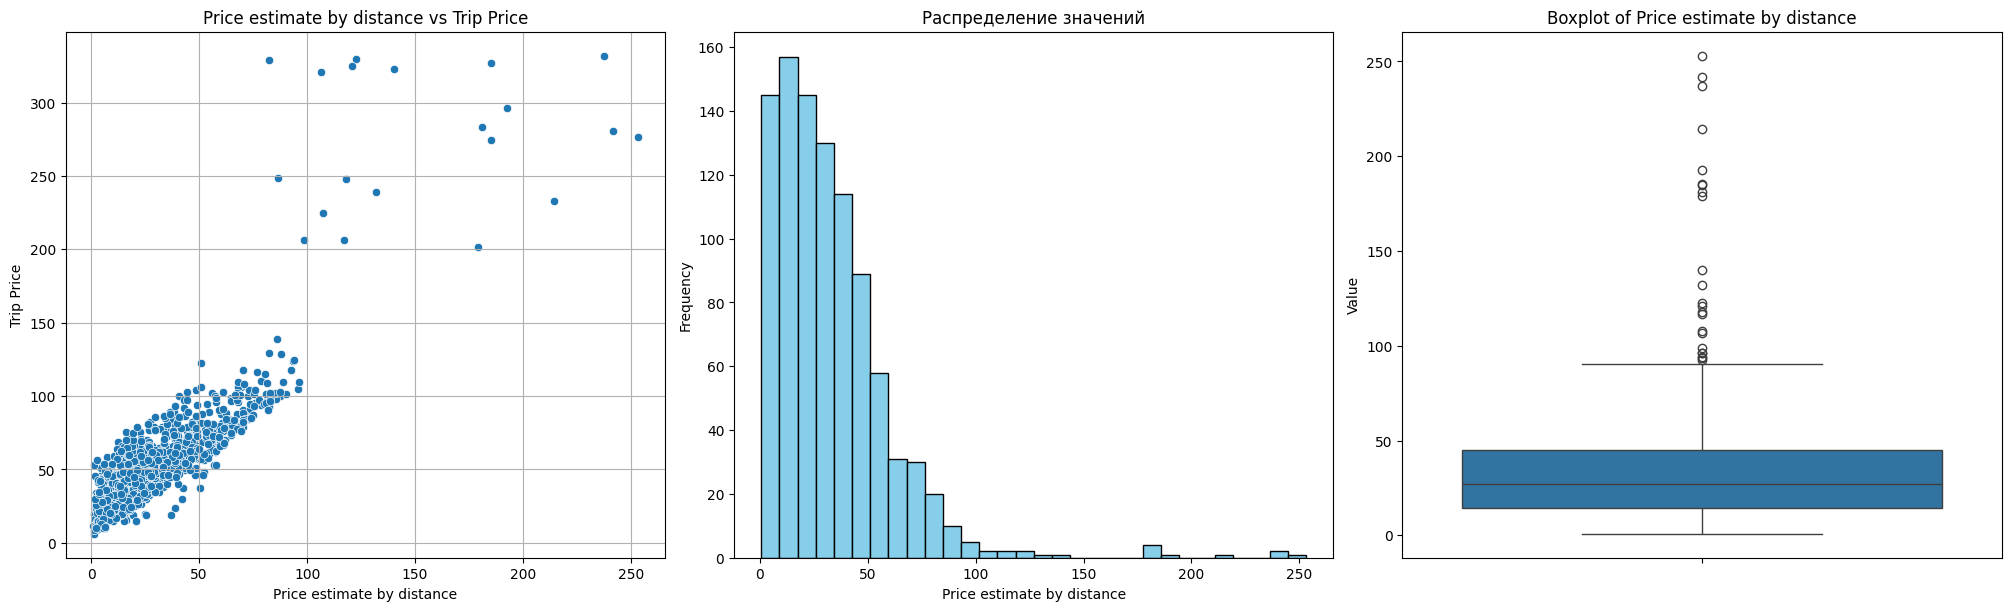

In [60]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6), constrained_layout=True)

sns.scatterplot(
    x="Per_Km_Rate__Trip_Distance_km",
    y="Trip_Price",
    data=optimized_ds_2,
    ax=axes[0]
)
axes[0].set_title("Price estimate by distance vs Trip Price")
axes[0].set_xlabel("Price estimate by distance")
axes[0].set_ylabel("Trip Price")
axes[0].grid(True)

axes[1].hist(optimized_ds_2["Per_Km_Rate__Trip_Distance_km"], bins=30, color="skyblue", edgecolor="black")
axes[1].set_title("Распределение значений")
axes[1].set_xlabel("Price estimate by distance")
axes[1].set_ylabel("Frequency")

sns.boxplot(
    y="Per_Km_Rate__Trip_Distance_km",
    data=optimized_ds_2,
    ax=axes[2]
)
axes[2].set_title("Boxplot of Price estimate by distance")
axes[2].set_ylabel("Value")

plt.show()

Как видно по графикам:

1. Целевая переменная действительно сильно зависит от значений рассматриваемого признака

2. Распределение значений для целевого признака слишком смещенное и имеет длинный "хвост"

Попробуем избавиться от выбросов, используя метод интерквартильного размаха.

In [61]:
Q1 = optimized_ds_2["Per_Km_Rate__Trip_Distance_km"].quantile(0.25)
Q3 = optimized_ds_2["Per_Km_Rate__Trip_Distance_km"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

optimized_ds_3 = optimized_ds_2[(lower_bound <= optimized_ds["Per_Km_Rate__Trip_Distance_km"]) & (optimized_ds["Per_Km_Rate__Trip_Distance_km"] <= upper_bound)]

# обучение модели

(X_train, y_train), (X_test, y_test) = generate_train_data(optimized_ds_3)

model = sklearn.ensemble.GradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

Mean Absolute Error (MAE): 3.2919
R-squared (R2): 0.9283


После удаления выбросов наблюдается значительное улучшение метрики MAE, что демонстрирует положительное влияние данной операции на качество модели. Однако, показатели метрики R2 немного уменьшились.

Таким образом, гипотеза о влиянии выбросов на результаты модели оказалась верной и дала ощутимый эффект.

#### Подбор гиперпараметров

Попробуем применить к модели градиентного бустинга гипотезу о том, что значения гиперпараметров, установленные по умолчанию, не являются оптимальным для данного датасета.

Попробуем подобрать наилучший набор значений, испльзуя алгоритм grid search.

In [62]:
param_grid = {
  "n_estimators": [15, 50, 100],
  "learning_rate": [0.01, 0.05, 0.1],
  "max_depth": [3, 4, 5],
  "min_samples_split": [10, 20],
  "min_samples_leaf": [4, 8],
  "subsample": [0.4, 0.8]
}

(X_train, y_train), (X_test, y_test) = generate_train_data(optimized_ds_3)
model = sklearn.ensemble.GradientBoostingRegressor(random_state=42)

grid_search = sklearn.model_selection.GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_absolute_error",
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Вывод результатов

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Best Parameters: {best_params}")
print_model_metrics(best_model, X_test, y_test)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters: {'learning_rate': 0.05, 'max_depth': 4, 'min_samples_leaf': 8, 'min_samples_split': 10, 'n_estimators': 100, 'subsample': 0.4}
Mean Absolute Error (MAE): 2.8811
R-squared (R2): 0.9490


Как видно по значениям метрик, подбор гиперпараметров дал положительный результат - модель стала показывать значительно лучшие показатели целевых метрик, что говорит нам о том, что значения гиперпараметров, установленные в модели по умолчанию, не являлись оптимальными.

### 4. Имплементация алгоритма машинного обучения

Перейдем теперь к собственной имплементации алгоритма дерева решения для задачи регрессии. Решение я реализовал в виде класса `MyRandomForestClassifier`, который имеет интерфейс, схожий с тем, что используется в библиотеке `sklearn`. присутствуют 2 метода: `fit` - для обучения модели, `predict` - для предсказания классов для уже обученной модели.

Так как смешанный лес является ансамблевым методом, то в его работе участвуют другие модели. В нашем случае это дерево решений. В качестве такой вспомогательной модели была взята имплементация алгоритма дерева решений из лабораторной работы №3.

Также, так как процесс обучения стал значительно дольше, то была добавлена строка для отслеживания прогресса обучения модели.

In [70]:
_PredictedClass = int


@dataclass
class _SplitInfo:
  index: int
  threshold: float


@dataclass
class _TreeNode:
  split_info: _SplitInfo
  left: Union["_TreeNode", _PredictedClass]
  right: Union["_TreeNode", _PredictedClass]



# TODO: make a base class for regressor & classifier
class MyDecisionTreeRegressor:
  def __init__(self, *, max_depth=float("inf")):
    self.__max_depth = max_depth
    self.__tree = None

  def __build_decision_tree(self, X, y, depth=0):
    n, _ = X.shape
    unique_classes = set(y)

    if len(unique_classes) == 1 or n <= 1:
      return unique_classes.pop()

    if depth >= self.__max_depth:
      return collections.Counter(y).most_common(1)[0][0]

    best_split = self.__get_best_split(X, y)
    left_part, right_part = self.__split_data(X, y, best_split)

    return _TreeNode(
      split_info=best_split,
      left=self.__build_decision_tree(*left_part, depth + 1),
      right=self.__build_decision_tree(*right_part, depth + 1),
    )

  def __split_data(self, X, y, split_info):
    x = X[:, split_info.index]
    left_ids = x <= split_info.threshold
    right_ids = x > split_info.threshold

    return (X[left_ids], y[left_ids]), (X[right_ids], y[right_ids])

  def __get_best_split(self, X, y):
    _, m = X.shape
    return max(
      (
        _SplitInfo(index=feature_index, threshold=threshold)
        for feature_index in range(m)
        for threshold in self.__get_thresholds(X, feature_index)
      ),
      key=lambda split_info: self.__get_variance_reduction(X, y, split_info.index, split_info.threshold),
      default=-float('inf'),
    )

  def __get_variance_reduction(self, X, y, feature_index, threshold):
    feature_values = X[:, feature_index]
    left_indices = feature_values <= threshold
    right_indices = feature_values > threshold

    if np.sum(left_indices) == 0 or np.sum(right_indices) == 0:
      return -float('inf')

    left_y = y[left_indices]
    right_y = y[right_indices]

    n = len(y)
    left_var = np.var(left_y) * len(left_y) / n
    right_var = np.var(right_y) * len(right_y) / n

    return np.var(y) - (left_var + right_var)

  def __get_thresholds(self, X, feature_id):
    return np.unique(X[:, feature_id])

  def __predict(self, x):
    cursor = self.__tree

    while isinstance(cursor, _TreeNode):
      feature_value = x[cursor.split_info.index]
      cursor = cursor.left if feature_value <= cursor.split_info.threshold else cursor.right

    return cursor

  def fit(self, X, y):
    self.__tree = self.__build_decision_tree(X, y)

  def predict(self, X):
    return np.array(list(map(self.__predict, X)))

In [78]:
class MyGradientBoostingRegressor:
  def __init__(self, *, trees_amount=100, learn_rate=0.1, tree_max_depth=3):
    self.__trees_amount = trees_amount
    self.__learn_rate = learn_rate
    self.__tree_max_depth = tree_max_depth

    self.__models = None

  def fit(self, X, y):
    y_pred = np.zeros(len(y))
    models = []

    for _ in tqdm.tqdm(range(self.__trees_amount)):
      model = MyDecisionTreeRegressor(max_depth=self.__tree_max_depth)
      model.fit(X, y - y_pred)

      y_pred += self.__learn_rate * model.predict(X)
      models.append(model)

    self.__models = models
    print()

  def predict(self, X):
    return sum(model.predict(X) for model in self.__models) * self.__learn_rate


In [79]:
(X_train, y_train), (X_test, y_test) = generate_train_data(baseline_ds)

model = MyGradientBoostingRegressor()
model.fit(X_train, y_train)

print_model_metrics(model, X_test, y_test)

100%|██████████| 100/100 [01:09<00:00,  1.45it/s]


Mean Absolute Error (MAE): 17.8299
R-squared (R2): 0.7779


Как видим, на неоптимизированном бейзлайне модель показывает неплохие результаты. Однако, по сравнению с моделью из пункта 2 они хуже: значительно выше значение для метрики "MAE" и некритично хуже значение для метрики "R2".

In [80]:
(X_train, y_train), (X_test, y_test) = generate_train_data(optimized_ds_3)

model = MyGradientBoostingRegressor(
    learn_rate=0.05,
    tree_max_depth=4,
    trees_amount=100,
)

model.fit(X_train, y_train)
print_model_metrics(model, X_test, y_test)

100%|██████████| 100/100 [01:22<00:00,  1.21it/s]


Mean Absolute Error (MAE): 4.3413
R-squared (R2): 0.9269


Однако, на оптимизированном бейзлайне имплементированная модель показала себя значительно лучше! Заметны сильные улучшения в метрике "MAE". Также, улучшилось
значение для метрики "R2".

Однако, по сравнению с моделью из пункта 3 это также не слишком хорошо: только значение метрики "R2" приблизилось к результату модели из пункта 3.
